In [2]:
import cebra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [3]:
df = pd.read_csv('../CEBRA/Data/tb2994_2D_info.csv')
df = df.T #csv file has the dimensions stored "wrong" for CEBRA
patient_data = df.to_numpy()
scaler = StandardScaler()
patient_data_standardized = scaler.fit_transform(patient_data)

In [3]:
print(cebra.models.get_options('offset*'))

['offset10-model', 'offset10-model-mse', 'offset5-model', 'offset1-model-mse', 'offset1-model', 'offset1-model-v2', 'offset1-model-v3', 'offset1-model-v4', 'offset1-model-v5', 'offset40-model-4x-subsample', 'offset20-model-4x-subsample', 'offset4-model-2x-subsample', 'offset36-model', 'offset36-model-dropout', 'offset36-model-more-dropout']


In [6]:
#if saved models are available:
model10 = cebra.CEBRA.load('./output/models/cebra/offset10model.pt')
model5 = cebra.CEBRA.load('./output/models/cebra/offset3model.pt')
model1 = cebra.CEBRA.load('./output/models/cebra/offset1model.pt')
latent_10off = model10.transform(patient_data)
latent_5off = model5.transform(patient_data)
latent_1off = model1.transform(patient_data)

In [4]:
model10= cebra.CEBRA(
    model_architecture='offset10-model',
    batch_size=1024,
    learning_rate=3e-4,
    output_dimension=8,  # 3D for visualization
    num_hidden_units = 512,
    max_iterations=10000,
    distance='euclidean',
    conditional='time',
    verbose=True
)

In [5]:
model5= cebra.CEBRA(
    model_architecture='offset5-model',
    batch_size=1024,
    learning_rate=3e-4,
    output_dimension=8,  # 3D for visualization
    num_hidden_units = 512,
    max_iterations=10000,
    distance='euclidean',
    conditional='time',
    verbose=True
)

In [6]:
model1= cebra.CEBRA(
    model_architecture='offset1-model',
    batch_size=1024,
    learning_rate=3e-4,
    output_dimension=8,  # 3D for visualization
    num_hidden_units = 512,
    max_iterations=10000,
    distance='euclidean',
    conditional='time',
    verbose=True
)

In [24]:
model10.fit(patient_data)
latent_10off = model10.transform(patient_data)

pos:  0.0038 neg:  5.1764 total:  5.1803 temperature:  1.0000: 100%|██████████| 10000/10000 [2:32:31<00:00,  1.09it/s] 


In [25]:
model5.fit(patient_data)
latent_5off = model5.transform(patient_data)

pos:  0.0040 neg:  5.1777 total:  5.1818 temperature:  1.0000: 100%|██████████| 10000/10000 [1:10:13<00:00,  2.37it/s]


In [26]:
model1.fit(patient_data)
latent_1off = model1.transform(patient_data)

pos:  0.0133 neg:  5.1808 total:  5.1942 temperature:  1.0000: 100%|██████████| 10000/10000 [11:58<00:00, 13.93it/s]


In [36]:
# saving models for later use
model10.save('./output/models/cebra/offset10model.pt')
model5.save('./output/models/cebra/offset3model.pt')
model1.save('./output/models/cebra/offset1model.pt')

## Visualizations from different Model results

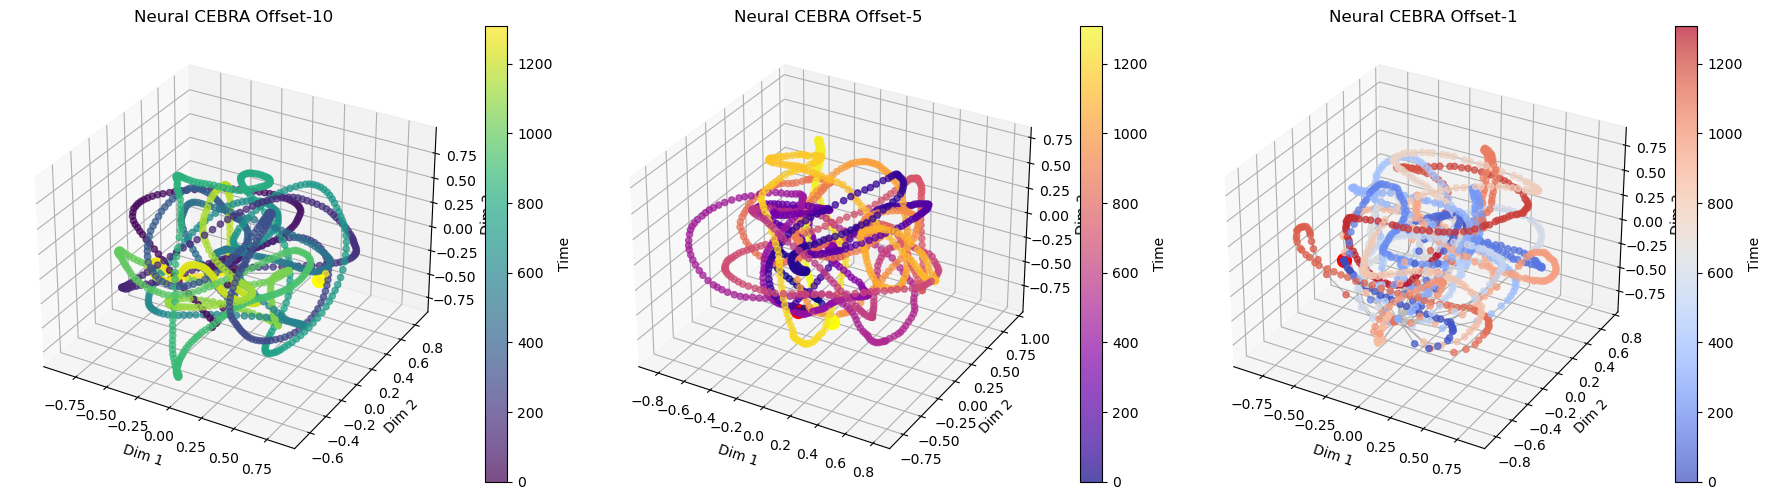

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create comparison 3D plots
fig = plt.figure(figsize=(18, 6))

models = [('Offset-10', latent_10off), ('Offset-5', latent_5off), ('Offset-1', latent_1off)]
colors = ['viridis', 'plasma', 'coolwarm']

for i, (model_name, latent_data) in enumerate(models):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    # Time-based coloring
    n_points = len(latent_data)
    time_colors = np.arange(n_points)
    
    # 3D trajectory plot
    scatter = ax.scatter(latent_data[:, 0], latent_data[:, 1], latent_data[:, 2],
                        c=time_colors, cmap=colors[i], s=20, alpha=0.7)
    
    # Add trajectory line
    ax.plot(latent_data[:, 0], latent_data[:, 1], latent_data[:, 2], 
            color='gray', alpha=0.5, linewidth=1)
    
    # Start/end markers
    ax.scatter(latent_data[0, 0], latent_data[0, 1], latent_data[0, 2], 
               color='red', s=100, alpha=1.0)
    ax.scatter(latent_data[-1, 0], latent_data[-1, 1], latent_data[-1, 2], 
               color='yellow', s=100, alpha=1.0)
    
    ax.set_title(f'Neural CEBRA {model_name}', fontsize=12)
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    
    plt.colorbar(scatter, ax=ax, shrink=0.8, label='Time')

plt.tight_layout()
plt.show()
plt.savefig('./output/visuals/cebra_models.png', dpi=300, bbox_inches='tight')

In [13]:
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    fig = make_subplots(
        rows=1, cols=3,
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
        subplot_titles=['Offset-10 Model', 'Offset-5 Model', 'Offset-1 Model']
    )
    
    latents = [latent_10off, latent_5off, latent_1off]
    for i, latent_data in enumerate(latents):
        fig.add_trace(
            go.Scatter3d(
                x=latent_data[:, 0],
                y=latent_data[:, 1],
                z=latent_data[:, 2],
                mode='markers+lines',
                marker=dict(
                    size=3,
                    color=np.arange(len(latent_data)),
                    colorscale='Viridis',
                    showscale=True if i == 0 else False
                ),
                line=dict(color='darkblue', width=2),
                name=f'Offset-{[10,5,1][i]}'
            ),
            row=1, col=i+1
        )
    
    fig.update_layout(
        title="Neural CEBRA Models Comparison",
        scene=dict(xaxis_title="Dim 1", yaxis_title="Dim 2", zaxis_title="Dim 3"),
        scene2=dict(xaxis_title="Dim 1", yaxis_title="Dim 2", zaxis_title="Dim 3"),
        scene3=dict(xaxis_title="Dim 1", yaxis_title="Dim 2", zaxis_title="Dim 3")
    )
    
    fig.write_html("./output/visuals/neural_cebra_comparison.html")
    print("Saved neural comparison as 'neural_cebra_comparison.html'")
    
except ImportError:
    print("Plotly not available")

Saved neural comparison as 'neural_cebra_comparison.html'


In [15]:
# Smooth the neural latents for cleaner visualization
from scipy.ndimage import gaussian_filter1d

def smooth_and_downsample(latent_data, sigma=2, downsample=5):
    """Smooth temporal dynamics and downsample for visualization"""
    # Smooth each dimension
    smoothed = np.zeros_like(latent_data)
    for dim in range(latent_data.shape[1]):
        smoothed[:, dim] = gaussian_filter1d(latent_data[:, dim], sigma=sigma)
    
    # Downsample every nth point
    downsampled = smoothed[::downsample]
    return downsampled

# Apply to all models
latent_10off_clean = smooth_and_downsample(latent_10off)
latent_5off_clean = smooth_and_downsample(latent_5off)
latent_1off_clean = smooth_and_downsample(latent_1off)

print(f"Original shape: {latent_10off.shape}")
print(f"Cleaned shape: {latent_10off_clean.shape}")

Original shape: (1311, 8)
Cleaned shape: (263, 8)


<Figure size 2000x1200 with 0 Axes>

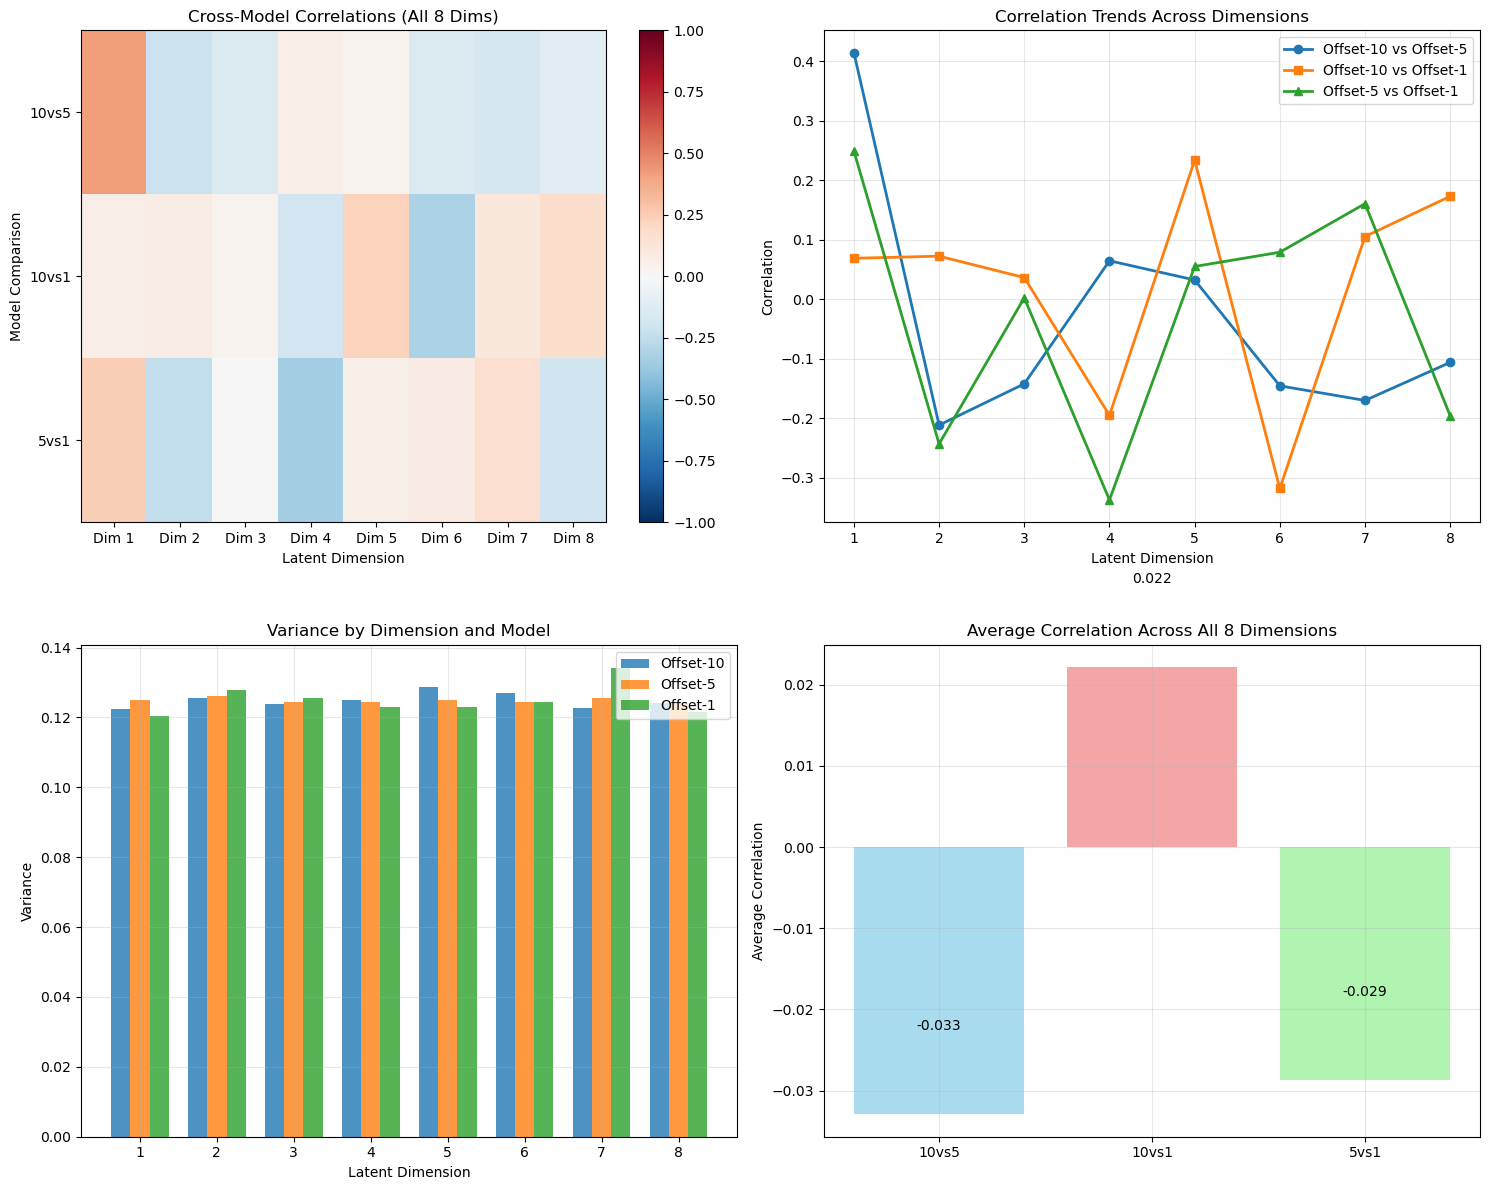

Correlation Summary (All 8 Dimensions):
Offset-10 vs Offset-5: mean=-0.033, std=0.192
Offset-10 vs Offset-1: mean=0.022, std=0.174
Offset-5 vs Offset-1: mean=-0.029, std=0.194


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
# Load latent from text embeddings
latent_3d = np.load('./output/embeddings/text_embeddings/latent_embeddings.npy')

# Compare neural and text embeddings side by side
fig = plt.figure(figsize=(20, 12))
# Compare all 8 dimensions across models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Individual dimension correlations (all 8 dims)
all_corrs = []
for dim in range(8):  # All 8 dimensions
    corr_10_5_dim, _ = pearsonr(latent_10off[:, dim], latent_5off[:, dim])
    corr_10_1_dim, _ = pearsonr(latent_10off[:, dim], latent_1off[:, dim])
    corr_5_1_dim, _ = pearsonr(latent_5off[:, dim], latent_1off[:, dim])
    all_corrs.append([corr_10_5_dim, corr_10_1_dim, corr_5_1_dim])

all_corrs = np.array(all_corrs)

# Correlation heatmap for all 8 dimensions
im = axes[0, 0].imshow(all_corrs.T, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[0, 0].set_title('Cross-Model Correlations (All 8 Dims)')
axes[0, 0].set_xlabel('Latent Dimension')
axes[0, 0].set_ylabel('Model Comparison')
axes[0, 0].set_xticks(range(8))
axes[0, 0].set_xticklabels([f'Dim {i+1}' for i in range(8)])
axes[0, 0].set_yticks(range(3))
axes[0, 0].set_yticklabels(['10vs5', '10vs1', '5vs1'])
plt.colorbar(im, ax=axes[0, 0])

# Plot correlation trends across dimensions
axes[0, 1].plot(range(1, 9), all_corrs[:, 0], 'o-', label='Offset-10 vs Offset-5', linewidth=2)
axes[0, 1].plot(range(1, 9), all_corrs[:, 1], 's-', label='Offset-10 vs Offset-1', linewidth=2)
axes[0, 1].plot(range(1, 9), all_corrs[:, 2], '^-', label='Offset-5 vs Offset-1', linewidth=2)
axes[0, 1].set_title('Correlation Trends Across Dimensions')
axes[0, 1].set_xlabel('Latent Dimension')
axes[0, 1].set_ylabel('Correlation')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(1, 9))

# Variance explained by each dimension for each model
variances_10 = np.var(latent_10off, axis=0)
variances_5 = np.var(latent_5off, axis=0)
variances_1 = np.var(latent_1off, axis=0)

x = np.arange(1, 9)
width = 0.25
axes[1, 0].bar(x - width, variances_10, width, label='Offset-10', alpha=0.8)
axes[1, 0].bar(x, variances_5, width, label='Offset-5', alpha=0.8)
axes[1, 0].bar(x + width, variances_1, width, label='Offset-1', alpha=0.8)
axes[1, 0].set_title('Variance by Dimension and Model')
axes[1, 0].set_xlabel('Latent Dimension')
axes[1, 0].set_ylabel('Variance')
axes[1, 0].legend()
axes[1, 0].set_xticks(range(1, 9))
axes[1, 0].grid(True, alpha=0.3)

# Overall model similarity (average correlation across all dims)
avg_corrs = np.mean(all_corrs, axis=0)
model_pairs = ['10vs5', '10vs1', '5vs1']
bars = axes[1, 1].bar(model_pairs, avg_corrs, alpha=0.7, 
                     color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1, 1].set_title('Average Correlation Across All 8 Dimensions')
axes[1, 1].set_ylabel('Average Correlation')
axes[1, 1].grid(True, alpha=0.3)

# Add correlation values on bars
for bar, corr in zip(bars, avg_corrs):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{corr:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Correlation Summary (All 8 Dimensions):")
print(f"Offset-10 vs Offset-5: mean={all_corrs[:, 0].mean():.3f}, std={all_corrs[:, 0].std():.3f}")
print(f"Offset-10 vs Offset-1: mean={all_corrs[:, 1].mean():.3f}, std={all_corrs[:, 1].std():.3f}")
print(f"Offset-5 vs Offset-1: mean={all_corrs[:, 2].mean():.3f}, std={all_corrs[:, 2].std():.3f}")
# Text embedding (from your earlier work)
ax1 = fig.add_subplot(2, 4, 1, projection='3d')
ax1.plot(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], 
         color='blue', alpha=0.8, linewidth=2)
ax1.set_title('Text Embeddings\n(Semantic Space)', fontsize=12)
ax1.set_xlabel('Dim 1'); ax1.set_ylabel('Dim 2'); ax1.set_zlabel('Dim 3')

# Neural embeddings (cleaned)
neural_models = [('Offset-10', latent_10off_clean), 
                ('Offset-5', latent_5off_clean), 
                ('Offset-1', latent_1off_clean)]

for i, (name, data) in enumerate(neural_models):
    ax = fig.add_subplot(2, 4, i+2, projection='3d')
    ax.plot(data[:, 0], data[:, 1], data[:, 2], 
            color=f'C{i+1}', alpha=0.8, linewidth=2)
    ax.set_title(f'Neural {name}\n(Brain Space)', fontsize=12)
    ax.set_xlabel('Dim 1'); ax.set_ylabel('Dim 2'); ax.set_zlabel('Dim 3')

# 2D projections for cleaner comparison
models_2d = [('Text', latent_3d), ('Neural 10-off', latent_10off_clean), 
             ('Neural 5-off', latent_5off_clean), ('Neural 1-off', latent_1off_clean)]

for i, (name, data) in enumerate(models_2d):
    ax = fig.add_subplot(2, 4, i+5)
    ax.plot(data[:, 0], data[:, 1], alpha=0.8, linewidth=2, 
            color='blue' if 'Text' in name else f'C{i}')
    ax.set_title(f'{name} - 2D Projection', fontsize=12)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('./output/visuals/inter_model_comparison.png', dpi=300, bbox_inches='tight')

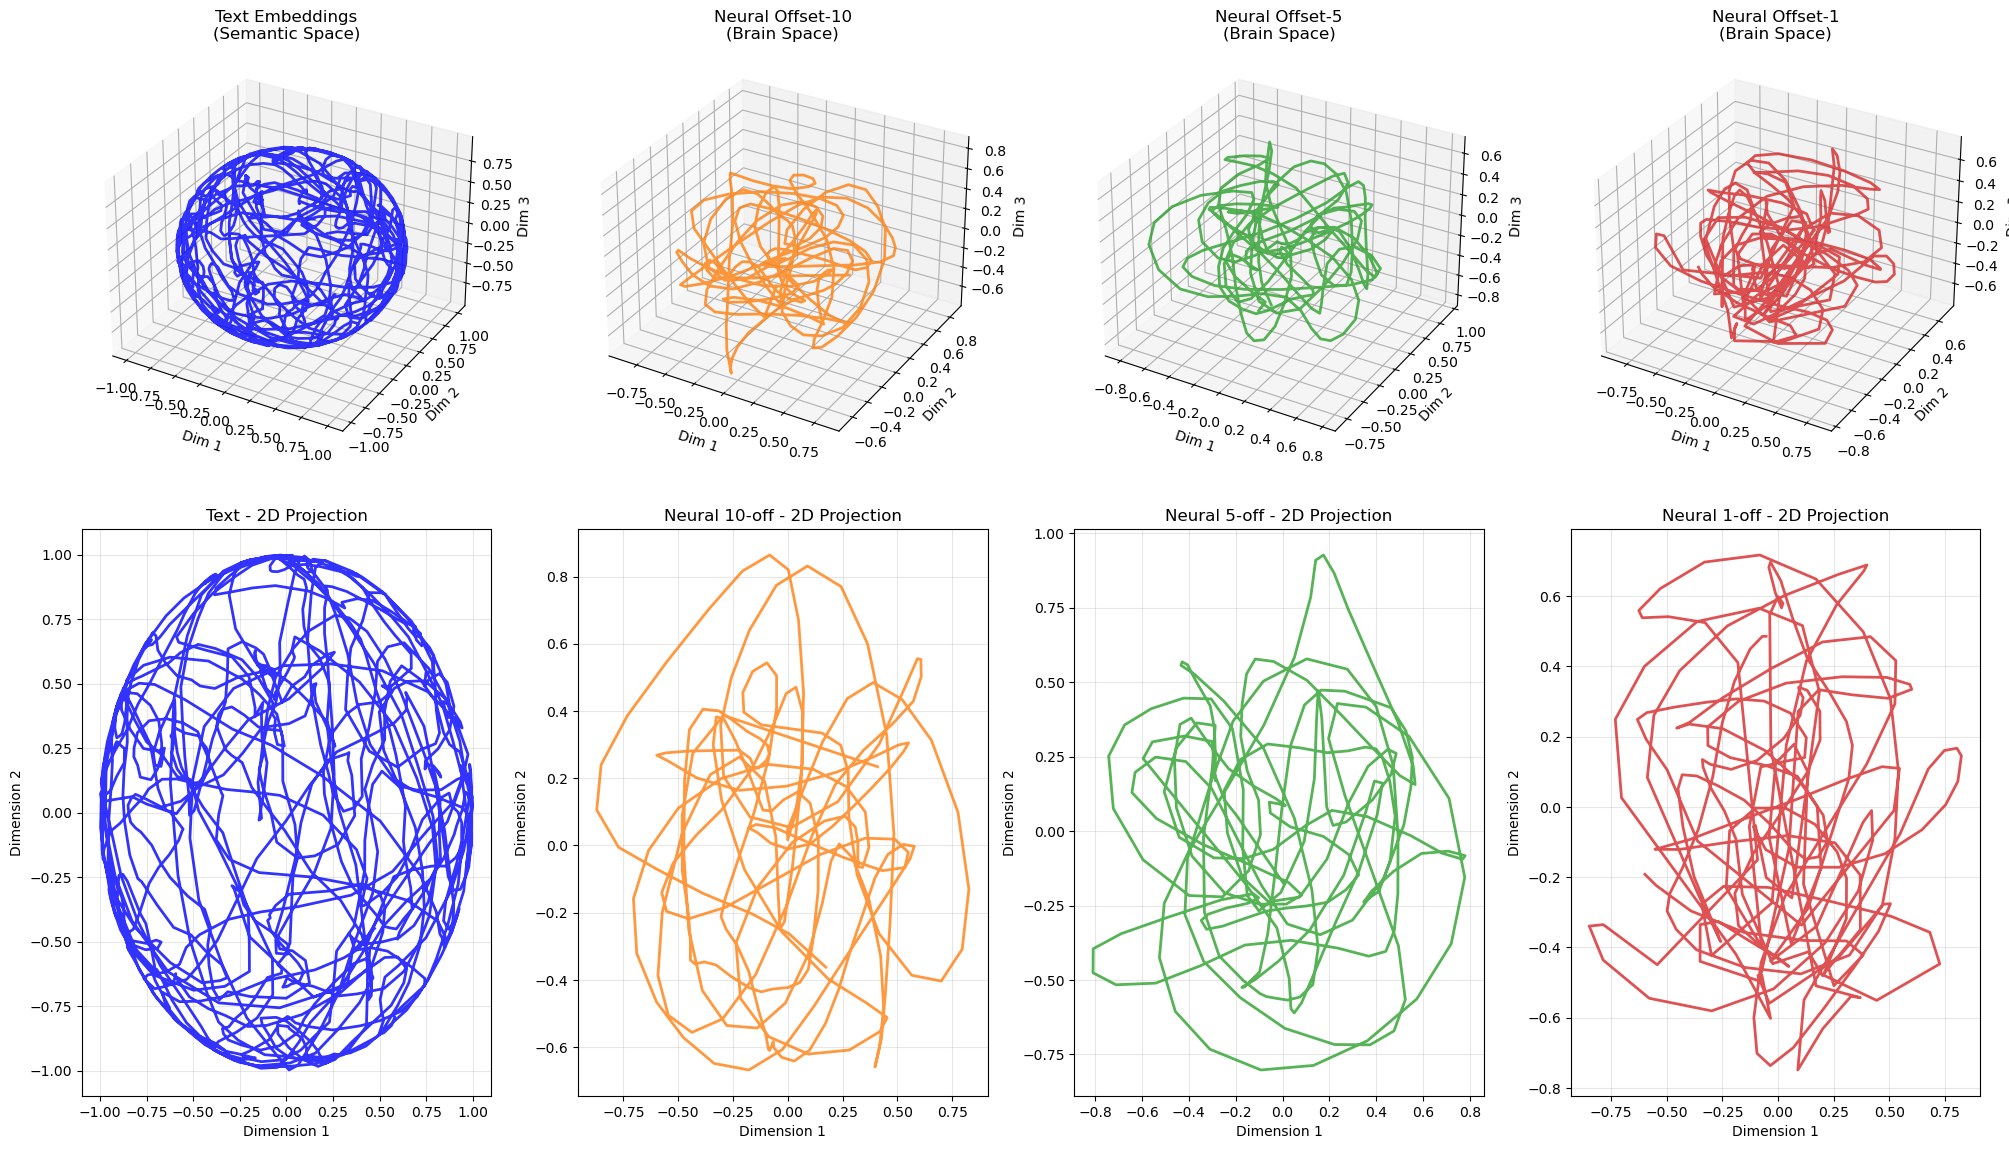

<Figure size 640x480 with 0 Axes>

In [17]:
# Compare neural and text embeddings side by side
fig = plt.figure(figsize=(20, 12))

# Text embedding (from your earlier work)
ax1 = fig.add_subplot(2, 4, 1, projection='3d')
ax1.plot(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], 
         color='blue', alpha=0.8, linewidth=2)
ax1.set_title('Text Embeddings\n(Semantic Space)', fontsize=12)
ax1.set_xlabel('Dim 1'); ax1.set_ylabel('Dim 2'); ax1.set_zlabel('Dim 3')

# Neural embeddings (cleaned)
neural_models = [('Offset-10', latent_10off_clean), 
                ('Offset-5', latent_5off_clean), 
                ('Offset-1', latent_1off_clean)]

for i, (name, data) in enumerate(neural_models):
    ax = fig.add_subplot(2, 4, i+2, projection='3d')
    ax.plot(data[:, 0], data[:, 1], data[:, 2], 
            color=f'C{i+1}', alpha=0.8, linewidth=2)
    ax.set_title(f'Neural {name}\n(Brain Space)', fontsize=12)
    ax.set_xlabel('Dim 1'); ax.set_ylabel('Dim 2'); ax.set_zlabel('Dim 3')

# 2D projections for cleaner comparison
models_2d = [('Text', latent_3d), ('Neural 10-off', latent_10off_clean), 
             ('Neural 5-off', latent_5off_clean), ('Neural 1-off', latent_1off_clean)]

for i, (name, data) in enumerate(models_2d):
    ax = fig.add_subplot(2, 4, i+5)
    ax.plot(data[:, 0], data[:, 1], alpha=0.8, linewidth=2, 
            color='blue' if 'Text' in name else f'C{i}')
    ax.set_title(f'{name} - 2D Projection', fontsize=12)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('./output/visuals/neural_textual_comparison.png', dpi=300, bbox_inches='tight')

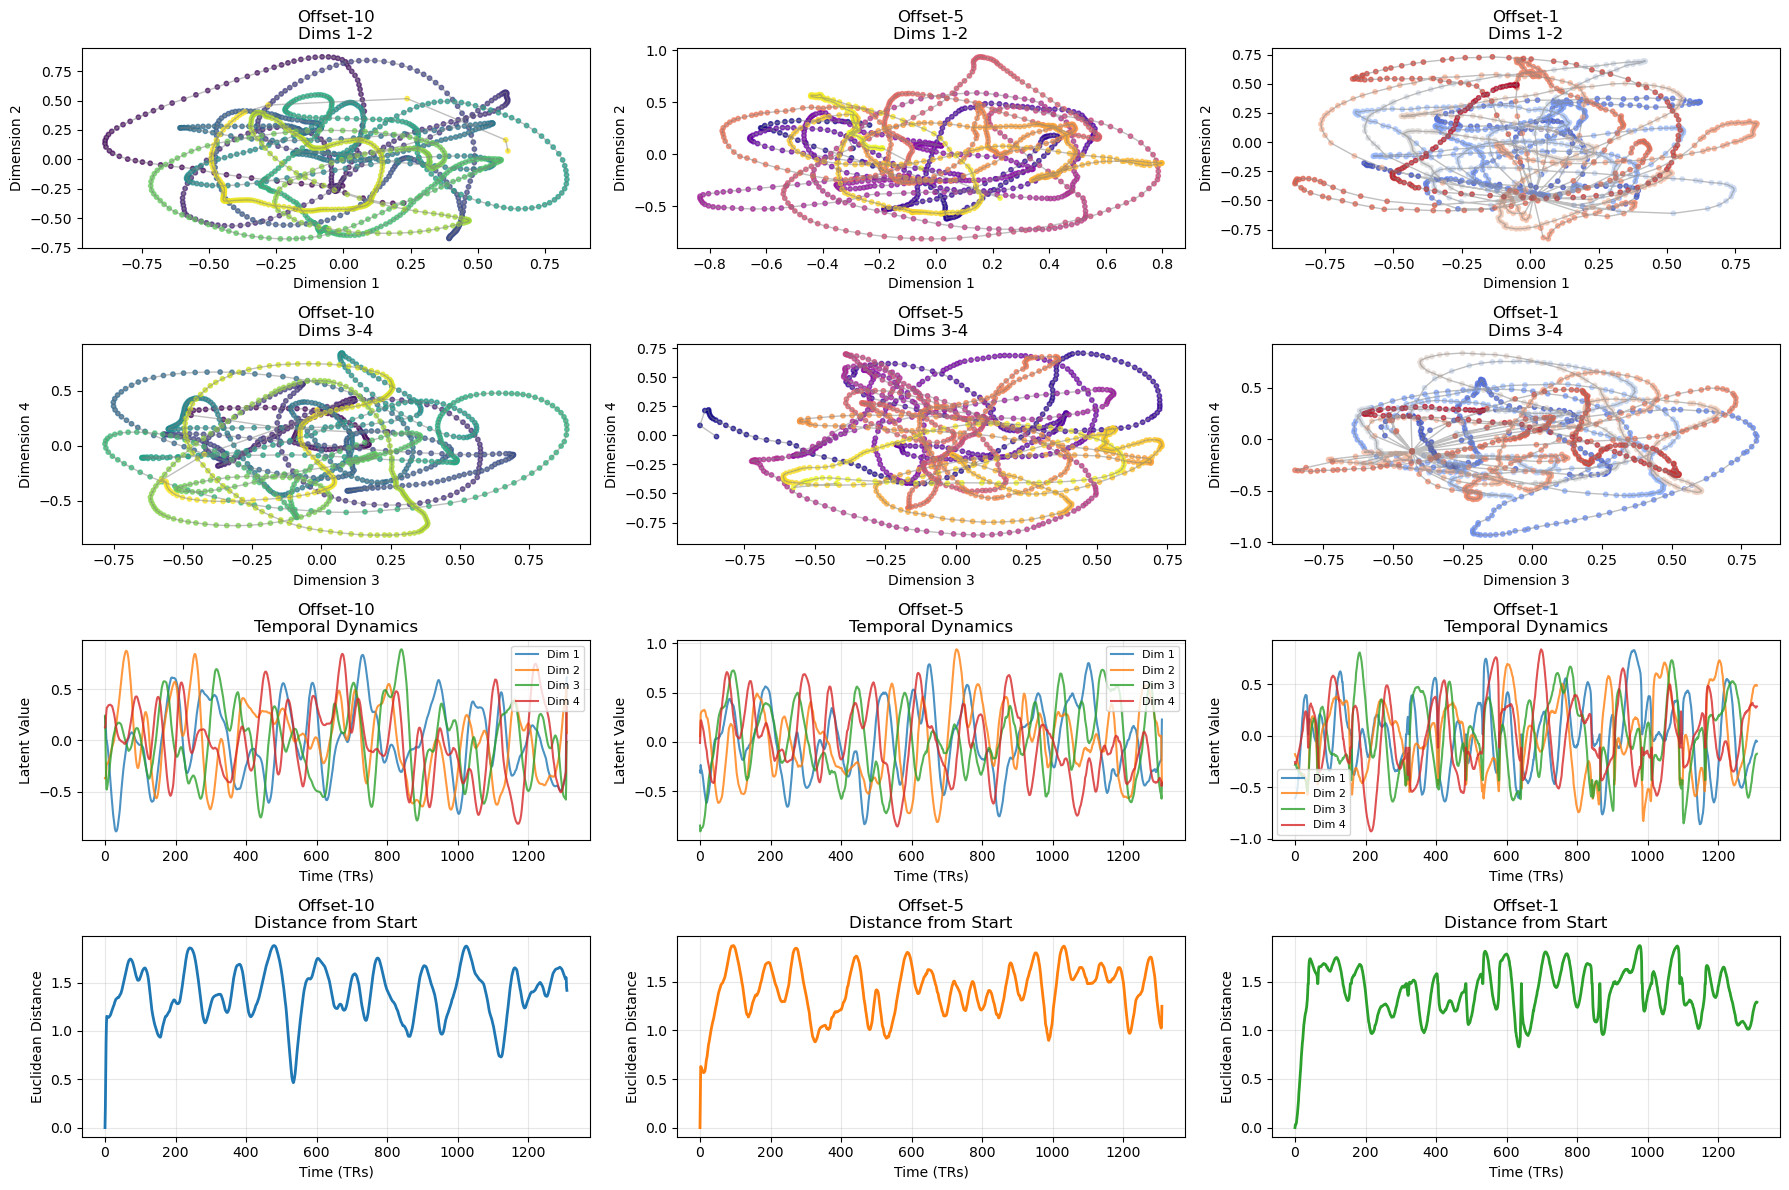

<Figure size 640x480 with 0 Axes>

In [18]:
# Code for multiple CEBRA visualization types
fig = plt.figure(figsize=(18, 12))

models = [('Offset-10', latent_10off), ('Offset-5', latent_5off), ('Offset-1', latent_1off)]
colors = ['viridis', 'plasma', 'coolwarm']

# 1. 2D projections of different dimension pairs
for i, (model_name, latent_data) in enumerate(models):
    # Dims 1-2
    ax1 = fig.add_subplot(4, 3, i+1)
    scatter = ax1.scatter(latent_data[:, 0], latent_data[:, 1], 
                         c=np.arange(len(latent_data)), cmap=colors[i], s=10, alpha=0.7)
    ax1.plot(latent_data[:, 0], latent_data[:, 1], color='gray', alpha=0.5, linewidth=1)
    ax1.set_title(f'{model_name}\nDims 1-2')
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')
    
    # Dims 3-4  
    ax2 = fig.add_subplot(4, 3, i+4)
    ax2.scatter(latent_data[:, 2], latent_data[:, 3], 
               c=np.arange(len(latent_data)), cmap=colors[i], s=10, alpha=0.7)
    ax2.plot(latent_data[:, 2], latent_data[:, 3], color='gray', alpha=0.5, linewidth=1)
    ax2.set_title(f'{model_name}\nDims 3-4')
    ax2.set_xlabel('Dimension 3')
    ax2.set_ylabel('Dimension 4')
    
    # Temporal dynamics (first 4 dims)
    ax3 = fig.add_subplot(4, 3, i+7)
    for dim in range(4):
        ax3.plot(latent_data[:, dim], label=f'Dim {dim+1}', alpha=0.8)
    ax3.set_title(f'{model_name}\nTemporal Dynamics')
    ax3.set_xlabel('Time (TRs)')
    ax3.set_ylabel('Latent Value')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    # Embedding distance over time
    ax4 = fig.add_subplot(4, 3, i+10)
    # Distance from first timepoint
    distances = np.linalg.norm(latent_data - latent_data[0], axis=1)
    ax4.plot(distances, color=f'C{i}', linewidth=2)
    ax4.set_title(f'{model_name}\nDistance from Start')
    ax4.set_xlabel('Time (TRs)')
    ax4.set_ylabel('Euclidean Distance')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('./output/visuals/cebra_misc_figures.png', dpi=300, bbox_inches='tight')

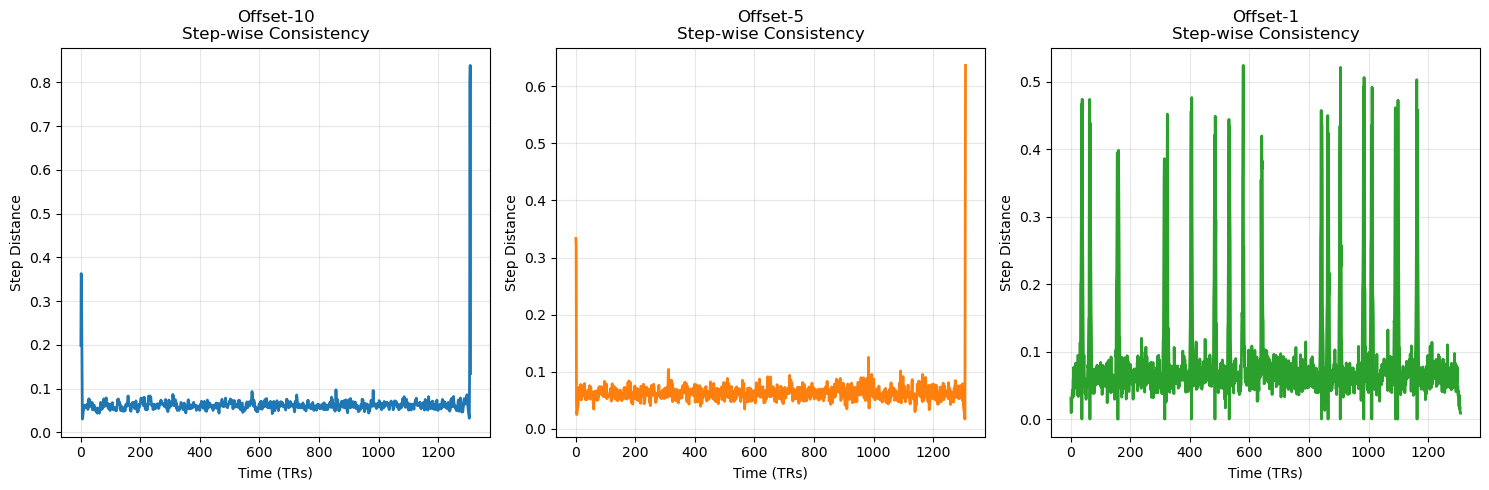

<Figure size 640x480 with 0 Axes>

In [19]:
# CEBRA consistency analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (model_name, latent_data) in enumerate(models):
    # Consistency: how much do embeddings change over time?
    consistency = []
    for t in range(1, len(latent_data)):
        dist = np.linalg.norm(latent_data[t] - latent_data[t-1])
        consistency.append(dist)
    
    axes[i].plot(consistency, color=f'C{i}', linewidth=2)
    axes[i].set_title(f'{model_name}\nStep-wise Consistency')
    axes[i].set_xlabel('Time (TRs)')
    axes[i].set_ylabel('Step Distance')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('./output/visuals/step-wise-consistency.png', dpi=300, bbox_inches='tight')

/u/ffilius/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/u/ffilius/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/u/ffilius/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



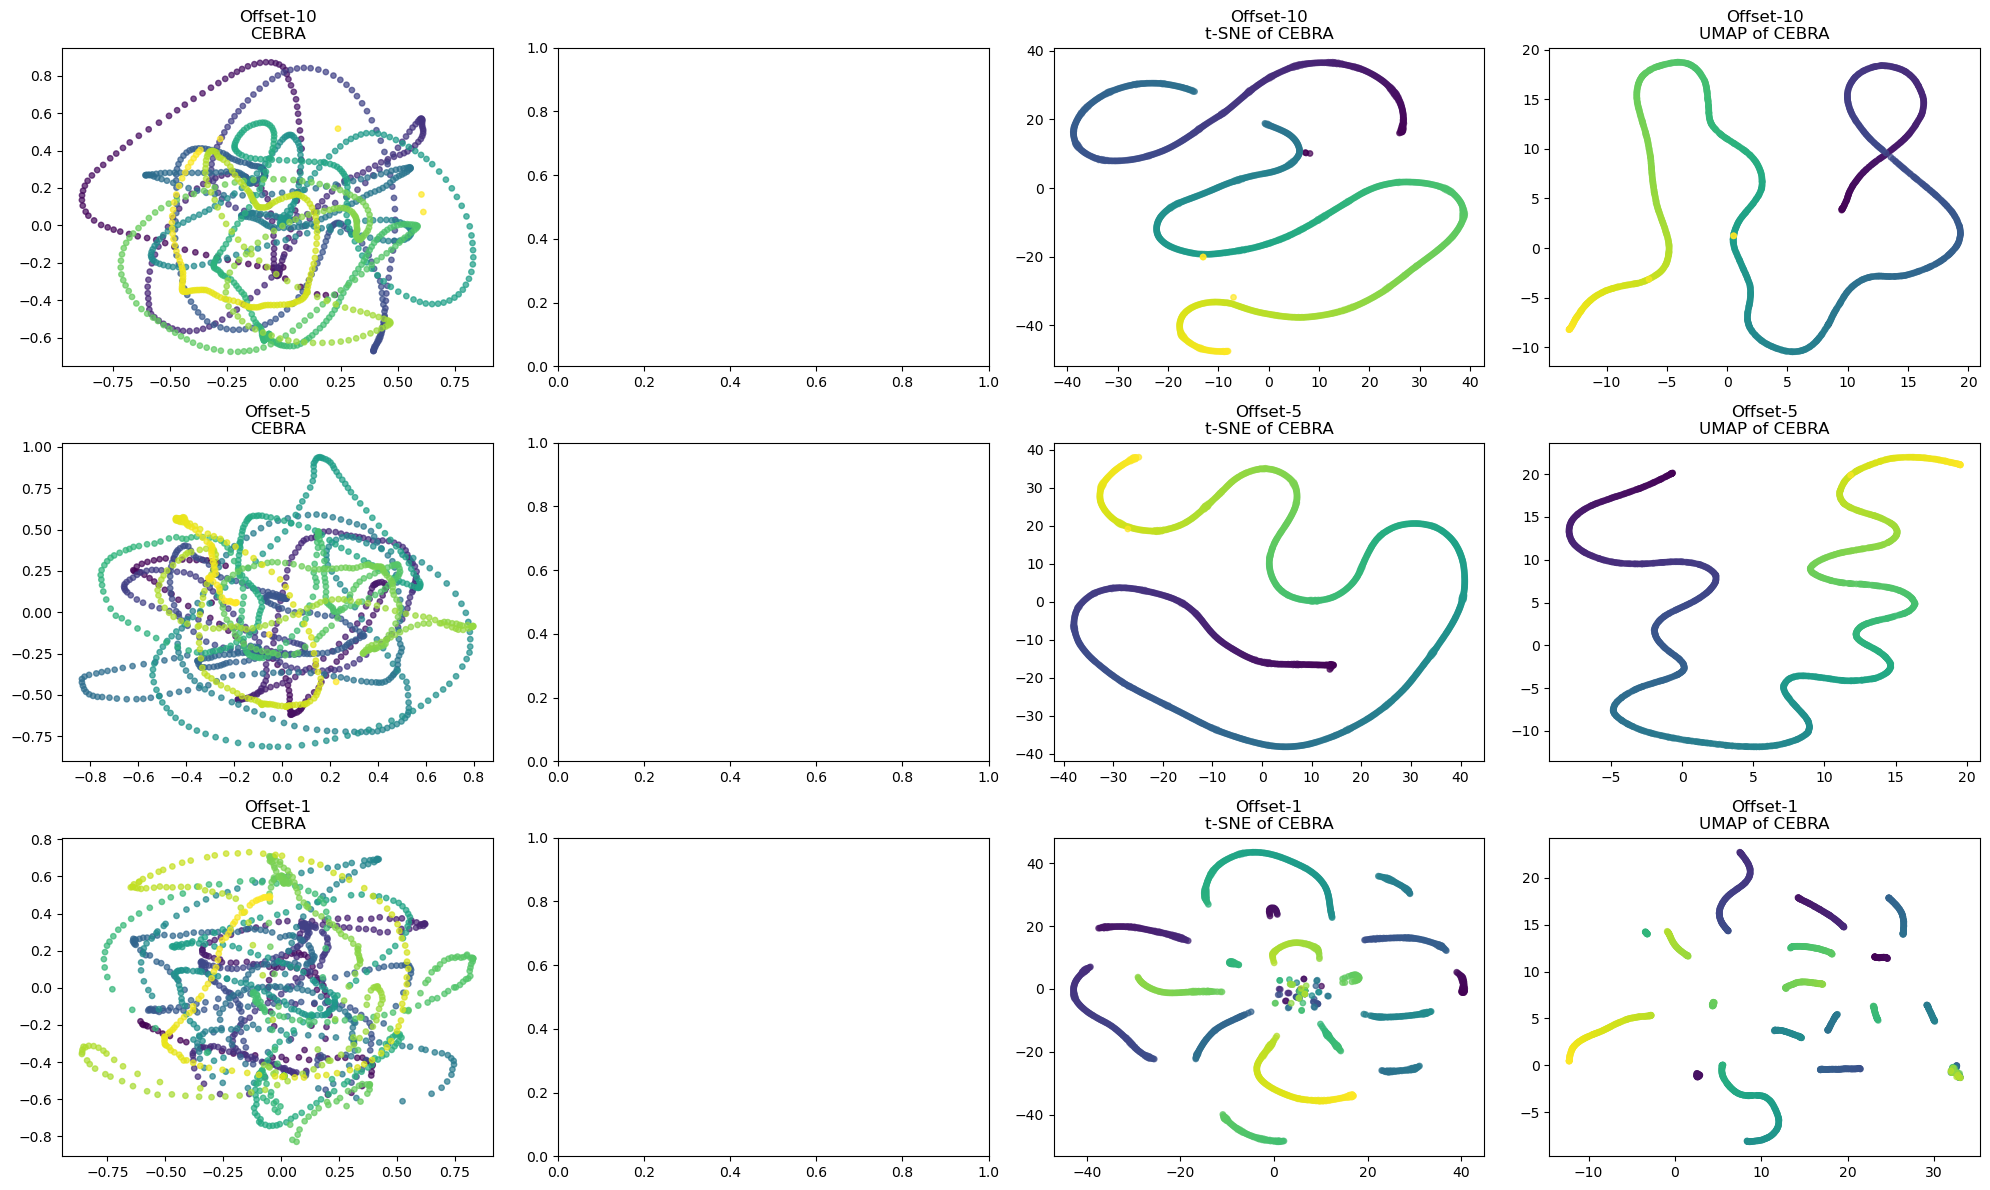

<Figure size 640x480 with 0 Axes>

In [20]:
# Compare CEBRA to t-SNE and UMAP
# t-SNE and UMAP just visualize the learned latent of CEBRA differently
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
neural_corrected = patient_data
#models = [('Offset-10', latent_10off), ('Offset-5', latent_5off), ('Offset-1', latent_1off)] #defined earlier
#colors = ['viridis', 'plasma', 'coolwarm']
for i, (model_name, latent_data) in enumerate(models):
    time_colors = np.arange(len(latent_data))
    
    # CEBRA (first 2 dims)
    axes[i, 0].scatter(latent_data[:, 0], latent_data[:, 1], 
                      c=time_colors, cmap='viridis', s=15, alpha=0.7)
    axes[i, 0].set_title(f'{model_name}\nCEBRA')
 
    # t-SNE comparison  
    if len(latent_data) > 50:  # t-SNE can be slow
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(latent_data)//4))
        tsne_result = tsne.fit_transform(latent_data)
        axes[i, 2].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                          c=time_colors, cmap='viridis', s=15, alpha=0.7)
    axes[i, 2].set_title(f'{model_name}\nt-SNE of CEBRA')
    
    #UMAP comparison
    umap_reducer = umap.UMAP(n_components=2, random_state=42, 
                            n_neighbors=min(15, len(latent_data)//4),
                            min_dist=0.1)
    umap_result = umap_reducer.fit_transform(latent_data)
    axes[i, 3].scatter(umap_result[:, 0], umap_result[:, 1], 
                      c=time_colors, cmap='viridis', s=15, alpha=0.7)
    axes[i, 3].set_title(f'{model_name}\nUMAP of CEBRA')

plt.tight_layout()
plt.show()
plt.savefig('./output/visuals/cebra_visual_comparison.png', dpi=300, bbox_inches='tight')

/u/ffilius/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/u/ffilius/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/u/ffilius/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



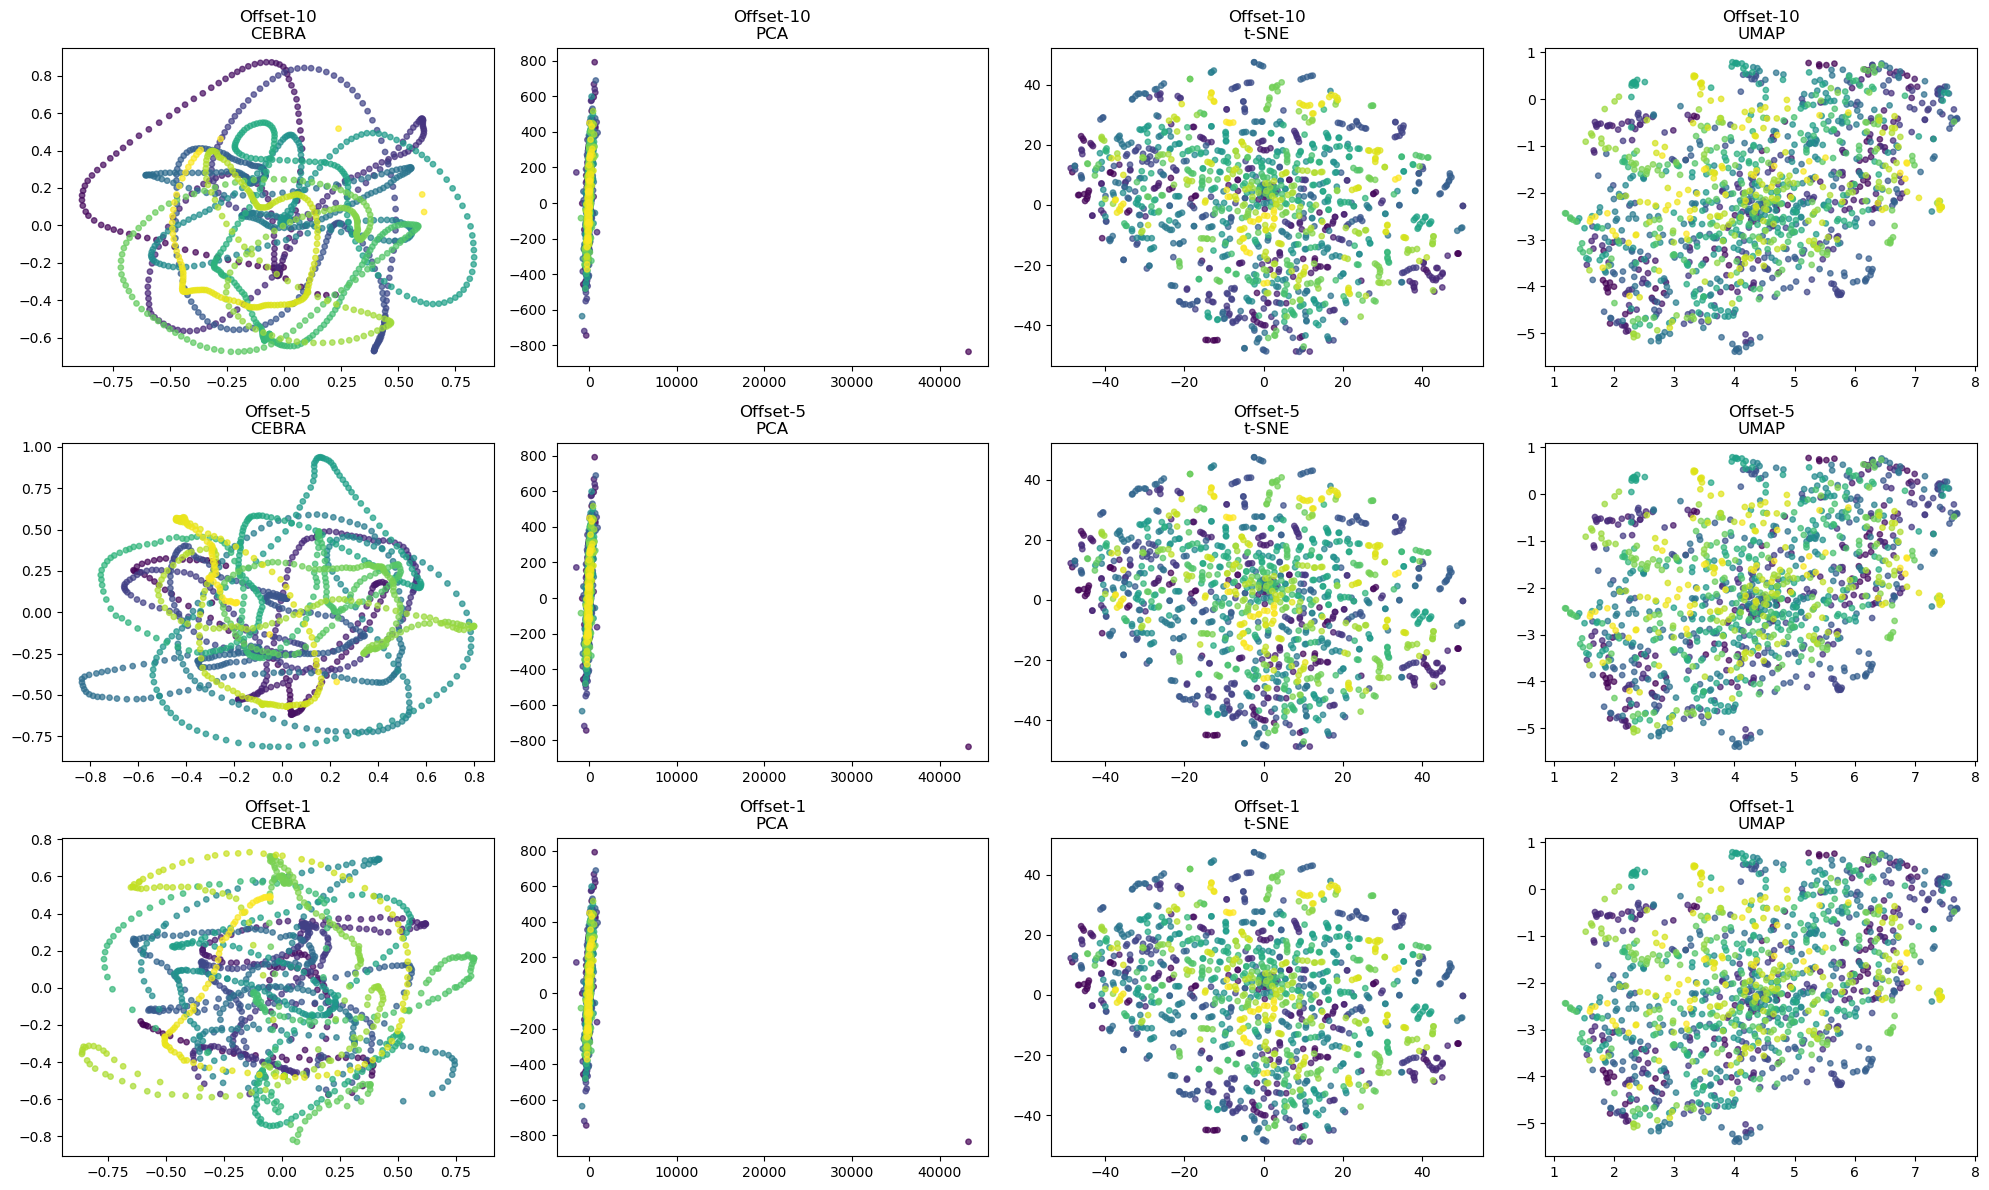

<Figure size 640x480 with 0 Axes>

In [21]:
# Compare CEBRA to PCA, t-SNE, and UMAP
# all on original data to compare learned latent
# UMAP and t-SNE got reduced features via PCA to enable computation of otherwise huge matrix

fig, axes = plt.subplots(3, 4, figsize=(20, 12))  # Changed to 3x4 for UMAP
neural_corrected = patient_data

# Simple preprocessing: reduce to 50 components for t-SNE/UMAP
pca_prep = PCA(n_components=50)
neural_reduced = pca_prep.fit_transform(neural_corrected)

for i, (model_name, latent_data) in enumerate(models):
    time_colors = np.arange(len(latent_data))
    
    # CEBRA (first 2 dims)
    axes[i, 0].scatter(latent_data[:, 0], latent_data[:, 1], 
                      c=time_colors, cmap='viridis', s=15, alpha=0.7)
    axes[i, 0].set_title(f'{model_name}\nCEBRA')
    
    # PCA comparison (on original neural data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(neural_corrected)
    axes[i, 1].scatter(pca_result[:, 0], pca_result[:, 1], 
                      c=time_colors, cmap='viridis', s=15, alpha=0.7)
    axes[i, 1].set_title(f'{model_name}\nPCA')
    
    # t-SNE comparison (on reduced neural data)
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(neural_reduced)//4))
    tsne_result = tsne.fit_transform(neural_reduced)
    axes[i, 2].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                      c=time_colors, cmap='viridis', s=15, alpha=0.7)
    axes[i, 2].set_title(f'{model_name}\nt-SNE')
    
    # UMAP comparison (on reduced neural data)
    umap_reducer = umap.UMAP(n_components=2, random_state=42, 
                            n_neighbors=min(15, len(neural_reduced)//10),
                            min_dist=0.1)
    umap_result = umap_reducer.fit_transform(neural_reduced)
    axes[i, 3].scatter(umap_result[:, 0], umap_result[:, 1], 
                      c=time_colors, cmap='viridis', s=15, alpha=0.7)
    axes[i, 3].set_title(f'{model_name}\nUMAP')

plt.tight_layout()
plt.show()
plt.savefig('./output/visuals/latents_comparison.png', dpi=300, bbox_inches='tight')